In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings

warnings.filterwarnings(
    "ignore",
    message="plotting functions contained within `_documentation_utils` are intended for nemos's documentation.",
    category=UserWarning,
)

:::{admonition} Download
:class: important render-all

This notebook can be downloaded as **{nb-download}`05_visual_coding.ipynb`**. See the button at the top right to download as markdown or pdf.
:::

# Exploring the Allen Institute's Visual Coding dataset


<div class="render-all">

This notebook serves as a group project: in groups of 4 or 5, you will analyze data from the [Visual Coding - Neuropixels dataset](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels), published by the Allen Institute. This dataset uses [extracellular electrophysiology probes](https://www.nature.com/articles/nature24636) to record spikes from multiple regions in the brain during passive visual stimulation.

To start, we will focus on the activity of neurons in the visual cortex (VISp) during passive exposure to full-field flashes of color either black (coded as "-1.0") or white (coded as "1.0") in a gray background. If you have time, you can apply the same procedure to other stimuli or brain areas.

In this notebook, the pre-filled section will first select visually responsive neurons in area VISp. Then, you will fit GLMs to the selected neurons using `nemos`.

As this is the last notebook, the instructions are a bit more hands-off: you will make more of the modeling decisions yourselves. As a group, you will use your neuroscience knowledge and the skills gained over this workshop to decide:
- How to avoid overfitting.
- What features to include in your GLMs.
- Which basis functions (and parameters) to use for each feature.
- How to regularize your features.
- How to evaluate your model.

At the end of this session, we will regroup to discuss the decisions people made and evaluate each others' models.

</div>

This notebook is adapted from Camila Maura's [Intro to GLM notebook](https://alleninstitute.github.io/openscope_databook/higher-order/GLM_pynapple_nemos.html) in the Allen Institute OpenScope Databook. See that notebook for a thorough introduction to using `pynapple` and `nemos` by fitting this dataset.

In [2]:
import workshop_utils
# Import everything
import jax
import matplotlib.pyplot as plt
import numpy as np
import pynapple as nap

# configure pynapple to ignore conversion warning
nap.nap_config.suppress_conversion_warnings = True

import nemos as nmo

# some helper plotting functions
from nemos import _documentation_utils as doc_plots

import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch

# configure plots some
plt.style.use(nmo.styles.plot_style)

## Downloading and preparing data

<div class="render-all">
In this section, we will download the data and extract the relevant parts for analysis and modeling. This section is largely presented to you as is, so that you can get to the substantive sections more quickly.

First we download and load the data into pynapple.
</div>

In [3]:
data = workshop_utils.fetch_data("visual_coding_data.zip")
flashes, units = [nap.load_file(d) for d in sorted(data)]

:::{admonition} Full dataset?
:class: dropdown

In this notebook, we are using only a subset of the full dataset. We've done a little bit of preprocessing and selection to reduce the size of the total file, which includes neurons from many different brain areas and stimulus paradigms.

To load the whole dataset for this session, run the following:

**WARNING:** this dataset is 2.6GB, so the following may take a while to run.

```{code-block} python
# Dataset information
dandiset_id = "000021"
dandi_filepath = "sub-726298249/sub-726298249_ses-754829445.nwb"

# Download the data using NeMoS
io = nmo.fetch.download_dandi_data(dandiset_id, dandi_filepath)

# load data using pynapple
data = nap.NWBFile(io.read(), lazy_loading=True)
```

`data` is then a pynapple NWB object, as we've interacted with in other notebooks. The following additional preprocessing was done to the NWB file before saving to the files we load at the beginning of this notebook:

```{code-block} python
# grab the spiking data
units = data["units"]

# map from electrodes to brain area
channel_probes = {}
for elec in data.nwb.electrodes:
    channel_id = elec.index[0]
    location = elec["location"].values[0]
    channel_probes[channel_id] = location

# Add a new column to include location in our spikes TsGroup
units.brain_area = [channel_probes[int(ch_id)] for ch_id in units.peak_channel_id]
# and only grab those located in area VISp
units = units[units.brain_area == "VISp"]

# drop unnecessary metadata
units.restrict_info(["rate", "quality", "brain_area"])

flashes = data["flashes_presentations"]
flashes.restrict_info(["color"])
```

See [Allen Institute website](https://portal.brain-map.org/circuits-behavior/visual-coding-neuropixels) for more information on the dataset.

:::
<div class="render-all">

Now that we have our spiking data, let's restrict our dataset to the relevant part.

![Visual stimuli set](../../_static/visual_stimuli_set.png)

During the flashes presentation trials, mice were exposed to white or black full-field flashes in a gray background, each lasting 250 ms, and separated by a 2 second inter-trial interval. In total, they were exposed to 150 flashes (75 black, 75 white).

</div>

In [4]:
# create a separate object for black and white flashes
flashes_white = flashes[flashes["color"] == "1.0"]
flashes_black = flashes[flashes["color"] == "-1.0"]

<div class="render-all">

Let's visualize our stimuli:

</div>

(1285.000869922, 1298.100869922)

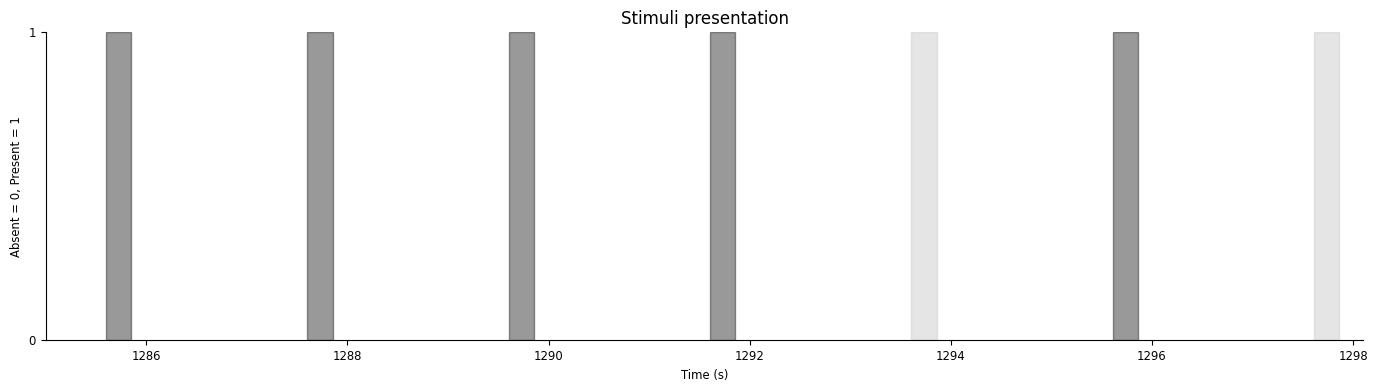

In [5]:
n_flashes = 5
n_seconds = 13
offset = .5

start = flashes["start"].min() - offset
end = start + n_seconds

fig, ax = plt.subplots(figsize = (17, 4))
for flash, c in zip([flashes_white, flashes_black], ["silver", "black"]):
    for fl in flash[:n_flashes]:
        ax.axvspan(fl.start[0], fl.end[0], color=c, alpha=.4, ec=c)      

plt.xlabel("Time (s)")
plt.ylabel("Absent = 0, Present = 1")
ax.set_title("Stimuli presentation")
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xlim(start-.1,end)
    

## Preliminary analyses and neuron selection

<div class="render-all">

In this section, we will select a subset of the neurons that are visually responsive, which we will fit our GLM to.

First, we'll construct a [IntervalSet](https://pynapple.org/generated/pynapple.IntervalSet.html) called `extended_flashes` which contains the peristimulus time. Right now, our `flashes` `IntervalSet` defines the start and end time for the flashes. In order to make sure we can model the pre-stimulus baseline and any responses to the stimulus being turned off, we would like to expand these intervals to go from 500 msecs before the start of the stimuli to 500 msecs after the end.

This `IntervalSet` will be the same shape as `flashes` and have the same metadata columns.

</div>

In [6]:
dt = .50 # 500 ms
start = flashes.start - dt # Start 500 ms before stimulus presentation
end = flashes.end + dt # End 500 ms after stimulus presentation

extended_flashes = nap.IntervalSet(start, end, metadata=flashes.metadata) 

<div class="render-all">

Now, we'll create two separate `IntervalSet` objects, `extended_flashes_black` and `extended_flashes_white`, which contain this info for only the black and the white flashes, respectively.

</div>

In [7]:
extended_flashes_white = extended_flashes[extended_flashes["color"] == "1.0"]
extended_flashes_black = extended_flashes[extended_flashes["color"] == "-1.0"]

<div class="render-all">

Now, we'll select our neurons. There are four criteria we want to use:

1. Brain area: we are interested in analyzing VISp units for this tutorial
2. Quality: we will only select "good" quality units. If you're curious, you can (optionally) [read more](https://alleninstitute.github.io/openscope_databook/visualization/visualize_unit_metrics.html) how about the Allen Institute defines quality.
3. Firing rate: overall, we want units with a firing rate larger than 2Hz around the presentation of stimuli
4. Responsiveness: we want units that actually respond to changes in the visual stimuli, i.e., their firing rate changes as a result of the stimulus.

We'll create a new `TsGroup`, `selected_units`, which includes only those units that meet the first three criteria, then check that it passes the assertion block.

</div>

In [8]:
# Filter units according criteria 1 & 2
selected_units = units[(units["brain_area"]=="VISp") & (units["quality"]=="good")] 

# Restrict around stimuli presentation
selected_units = selected_units.restrict(extended_flashes) 

# Filter according to criterion 3
selected_units = selected_units[(selected_units["rate"]>2.0)]

<div class="render-all">

Now, in order to determine the responsiveness of the units, it's helpful to use the [compute_perievent](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent) function: this will align units' spiking timestamps with the onset of the stimulus repetitions and take an average over them.

Let's use that function to construct two separate perievent dictionaries, one aligned to the start of the white stimuli, one aligned to the start of the black, and they should run from 250 msec before to 500 msec after the event.

(compute-perievent-full)=

</div>

In [9]:
# Set window of perievent 500 ms before and after the start of the event
window_size = (-.250, .500) 

peri_white = nap.compute_perievent(timestamps=selected_units,
                                   tref=nap.Ts(flashes_white.start),
                                   minmax=window_size)
peri_black = nap.compute_perievent(timestamps=selected_units,
                                   tref=nap.Ts(flashes_black.start),
                                   minmax=window_size)

<div class="render-all">

Visualizing these perievents can help us determine what features we'll want to include in our GLM. The following helper function should help.

</div>

In [10]:
def plot_raster_psth(peri, units, color_flashes, n_units=9, start_unit=0, bin_size=.005, smoothing=0.015):
    """
    Plot perievent time histograms (PSTHs) and raster plots for multiple units.

    Parameters:
    -----------
    peri : dict
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    units : dict
        Dictionary of neural units, e.g., spike trains or trial-aligned spike events.
    color_flashes : str
        A label indicating the flash color condition ('black' or 'white'), used for visual styling.
    n_units : int
        The number of units to visualize.
    start_unit : int
        The index of the unit to start with.
    bin_size : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PSTH traces.
    """

    # Layout setup: 9 columns (units), 2 rows (split vertically into PSTH and raster plot)
    n_cols = n_units
    n_rows = 2
    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(n_cols*2, 4))

    colors = plt.cm.tab10.colors

    # Extract unit names for iteration
    units_list = list(units.keys())[start_unit:start_unit+n_units]

    for i, unit in enumerate(units_list):
        u = peri[unit]
        line_color = colors[i % len(colors)]
        ax = axes[0, i]

        # Plot PSTH (smoothed firing rate)
        ax.plot(
            (np.mean(u.count(bin_size), 1) / bin_size).smooth(std=smoothing),
            linewidth=2,
            color=line_color
        )
        ax.axvline(0.0)  # Stimulus onset line

        span_color = "black" if color_flashes == "black" else "silver"
        ax.axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
        ax.set_xlim(-0.25, 0.50)
        ax.set_title(f'{unit}')

        # Plot raster
        ax = axes[1, i]
        ax.plot(u.to_tsd(), "|", markersize=1, color=line_color, mew=2)
        ax.axvline(0.0)
        ax.axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")
        ax.set_ylim(0, 75)
        ax.set_xlim(-0.25, 0.50)

    # Y-axis and title annotations
    axes[0, 0].set_ylabel("Rate (Hz)")
    axes[1, 0].set_ylabel("Trial")
    if n_rows > 2:
        axes[2, 0].set_ylabel("Rate (Hz)")
        axes[3, 0].set_ylabel("Trial")
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PSTH & Spike Raster Plot - {color_flashes} flashes', ha='center')
    plt.tight_layout()

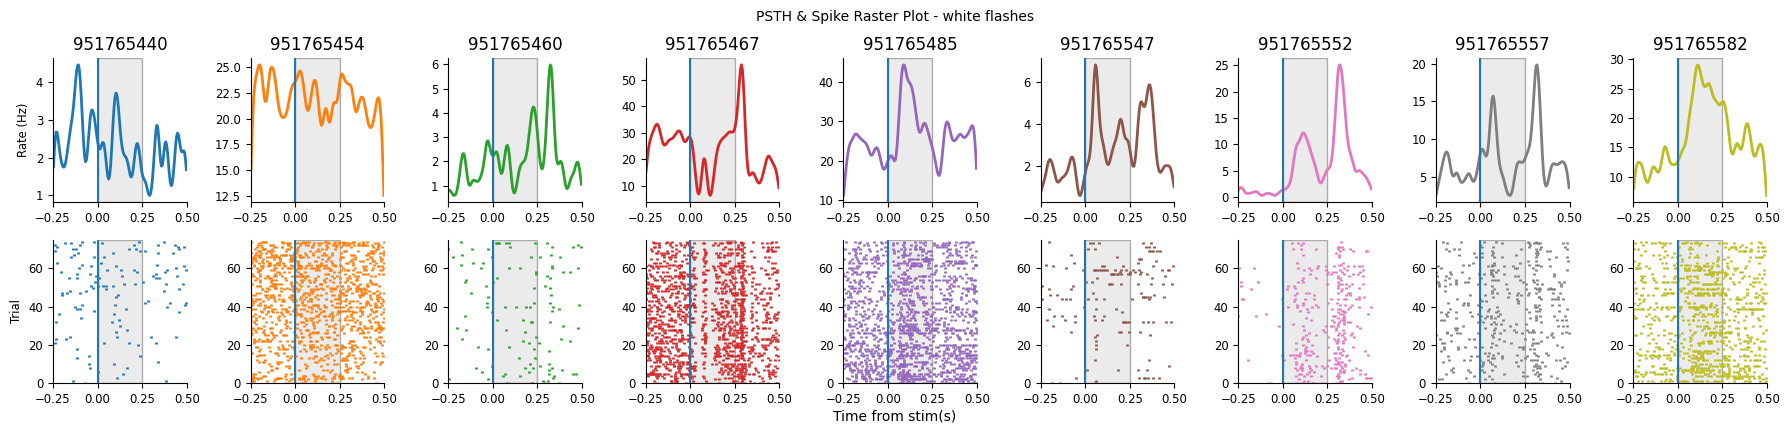

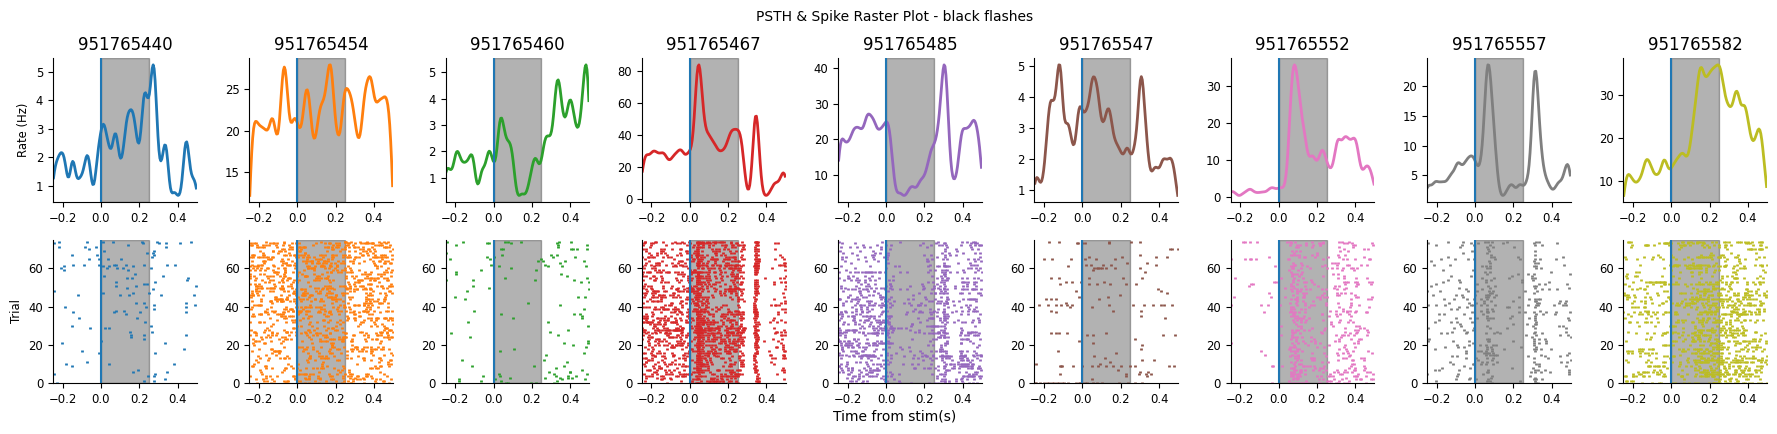

In [11]:
# called like this, the function will visualize the first 9 units. play with the n_units
# and start_unit arguments to see the other units.
plot_raster_psth(peri_white, selected_units, "white", n_units=9, start_unit=0)
plot_raster_psth(peri_black, selected_units, "black", n_units=9, start_unit=0)

<div class="render-all">

You could manually visualize each of our units and select those that appear, from their PSTH to be responsive.

However, it would be easier to scale (and more reproducible) if you came up with some measure of responsiveness. So how do we compute something that captures "this neuron responds to visual stimuli"? Here, we will define "responsiveness" as the normalized difference in average firing rate between during stimulus presentation and before the stimulus was presented. We'll define a function that does that in the following hidden cell.

If you have other ideas and the time to explore them, you can return to this section and try other definitions of responsiveness.

</div>

In [12]:
def get_responsiveness(perievents, bin_size=0.005):
    """Calculate responsiveness for each neuron. This is computed as:

    post_presentation_avg  : 
        Average firing rate during presentation (250 ms) of stimulus across
        all instances of stimulus. 

    pre_presentation_avg :
        Average firing rate prior (250 ms) to the presentation of stimulus
        across all instances prior of stimulus. 

    responsiveness : 
        abs((post_presentation_avg - pre_presentation_avg) / (post_presentation_avg + pre_presentation_avg))

    Larger values indicate higher responsiveness to the stimuli.
        
    Parameters
    ----------
    perievents : TsGroup
        Contains perievent information of a subset of neurons
    bin_size : float
        Bin size for calculating spike counts

    Returns
    ----------   
    resp_array : np.array
        Array of responsiveness information.

    """
    resp_dict = {}
    resp_array = np.zeros(len(perievents.keys()), dtype=float)

    for index, peri in enumerate(perievents.values()):
        # Count the number of timestamps in each bin_size bin.
        peri_counts = peri.count(bin_size)

        # Compute average spikes for each millisecond in the
        # the 250 ms before stimulus presentation
        pre_presentation = np.mean(peri_counts, 1).restrict(nap.IntervalSet([-.25,0]))

        # Compute average spikes for each millisecond in the
        # the 250 ms after stimulus presentation
        post_presentation = np.mean(peri_counts, 1).restrict(nap.IntervalSet([0,.25]))

        pre_presentation_avg = np.mean(pre_presentation)
        post_presentation_avg = np.mean(post_presentation)
        responsiveness = abs((post_presentation_avg - pre_presentation_avg) / (post_presentation_avg + pre_presentation_avg))

        resp_array[index] = responsiveness

    return resp_array

In [13]:
# Compute the responsiveness measure
responsiveness_white = get_responsiveness(peri_white)
responsiveness_black = get_responsiveness(peri_black)

# Get threshold for top 15% most responsive
thresh_black = np.percentile(responsiveness_black, 85)
thresh_white = np.percentile(responsiveness_white, 85)

# Only keep units that are within the 15% most responsive for either black or white
selected_units = selected_units[(responsiveness_black > thresh_black) | (responsiveness_white > thresh_white)]

<div class="render-all">

Let's visualize the selected units PSTHs to make sure they all look reasonable:

</div>

Remaining units: 19


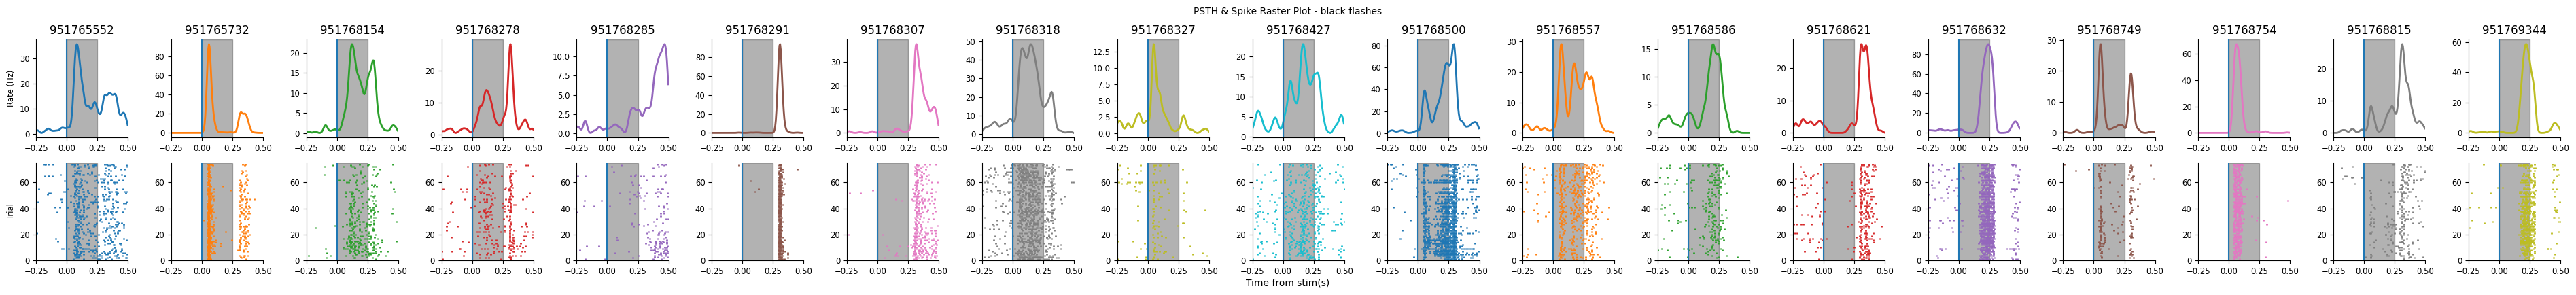

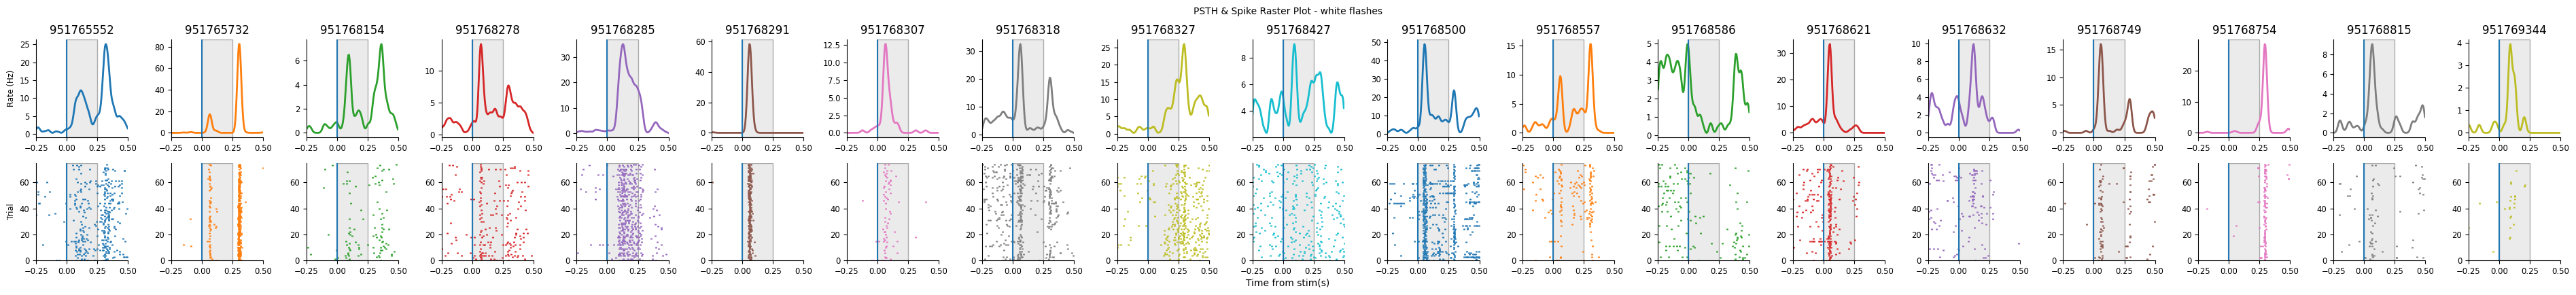

In [14]:
print(f"Remaining units: {len(selected_units)}")
peri_white = {k: peri_white[k] for k in selected_units.index}
peri_black = {k: peri_black[k] for k in selected_units.index}

plot_raster_psth(peri_black, selected_units, "black", n_units=len(peri_black))
plot_raster_psth(peri_white, selected_units, "white", n_units=len(peri_white))

## Avoiding overfitting

<div class="render-all">

As we've seen throughout this workshop, it is important to avoid overfitting your model. We've covered two strategies for doing so: either separate your dataset into train and test subsets or set up a cross-validation scheme. Pick one of these approaches and use it when fitting your GLM model in the next section.

You might find it helpful to refer back to the [advanced nemos ("How to know when to regularize" header)](sklearn-cv-full) notebook and / or to use the following pynapple functions: [IntervalSet.set_diff](https://pynapple.org/generated/pynapple.IntervalSet.set_diff.html), [IntervalSet.union](https://pynapple.org/generated/pynapple.IntervalSet.union.html), [TsGroup.restrict](https://pynapple.org/generated/pynapple.TsGroup.restrict.html) (see [phase precession notebook ("Aside: Cross-validation" admonition)](phase-precess-cv-users)).

:::{admonition} Hints
:class: hint

Throughout the rest of the notebook we'll include hints. They'll either be links back to earlier notebooks from this workshop that show an example of how to do the step in question, or a hint like this, which you can expand to get a hint.

:::

</div>

Again, multiple viable ways of solving this. Here's the simplest: grab every third flash and use that as the test set.

In [15]:
# We take one every three flashes (33% of all flashes of test)
flashes_test_white = extended_flashes_white[::3]
flashes_test_black = extended_flashes_black[::3]
# The remaining is separated for training
flashes_train_white = extended_flashes_white.set_diff(flashes_test_white)
flashes_train_black = extended_flashes_black.set_diff(flashes_test_black)
# Merge both stimuli types in a single interval set
flashes_test = flashes_test_white.union(flashes_test_black)
flashes_train = flashes_train_white.union(flashes_train_black)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/pynapple/core/interval_set.py:708: UserWarning: metadata incompatible with union method. dropping metadata from result
  warnings.warn(


/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/pynapple/core/interval_set.py:708: UserWarning: metadata incompatible with union method. dropping metadata from result
  warnings.warn(


(visual-glm-full)=
## Fit a GLM

<div class="render-all">

In this section, you will use nemos to build a GLM. There are a lot of scientific decisions to be made here, so we suggest starting simple and then adding complexity. Construct a design matrix with a single predictor, using a basis of your choice, then construct, fit, and score your model to a single neuron (remembering to either use your train/test or cross-validation to avoid overfitting). Then add regularization to your GLM. Then return to the beginning and add more predictors. Then fit all the neurons. Then evaluate what basis functions and parameters are best for your predictors. Then use the tricks we covered in [the advanced nemos notebook ("Feature selection" header)](sklearn-feature-selection-full) to evaluate whether which predictors are necessary for your model, which are the most important.

You don't have to exactly follow those steps, but make sure you can go from beginning to end before getting too complex.

Good luck and we look forward to seeing what you come up with!


</div>

There are many ways to do this. We'll show fitting a single neuron `GLM` to a variety of stimulus-derived predictors. You can also see [the original notebook](https://alleninstitute.github.io/openscope_databook/higher-order/GLM_pynapple_nemos.html#adding-coupling-as-a-new-predictor) for a `PopulationGLM` that adds coupling.

### Prepare data

<div class="render-all">

- Decide on bin size and create spike count data. (Hint: review the [current injection notebook ("Extending the model to use injection history" header)](current-inj-basic-full).)

</div>

<div class="render-user">  
```{code-cell} ipython3
bin_size = 
units_counts = 
```
</div>

In [16]:
bin_size = .005
units_counts = selected_units.count(bin_size, ep=extended_flashes)

### Construct design matrix

<div class="render-all">

- Decide on feature(s).
    - The code block below constructs `stim`, a `TsdFrame` containing 1s whenever the stimulus is being presented (in separate columns for white and black).
    - You can use this, but you may also want to perform additional computations on `stim` to construct other features.
- Decide on basis. (Hint: review the [current injection ("Extending the model to use injection history")](current-inj-basis-full) or [place cell ("Select basis" header)](sklearn-basis-full) notebooks.)
    - If you set the `label` argument for your basis objects, interpreting the output will be easier.
- Construct design matrix. (Hint: review the [place cell ("Basis evaluation" header)](basis-eval-place-cells-users) notebook.)

:::{admonition} What features should I include?
:class: hint dropdown

If you're having trouble coming up with features to include, here are some possibilities:
- Stimulus, using `stim`. (Review the [current injection ("Preparing data" header)](current-inj-prep-full) notebook.)
- Stimulus onset. (Hint: you can use [numpy.diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) to find when the stimulus transitions from off to on.)
- Stimulus offset. (Hint: you can use [numpy.diff](https://numpy.org/doc/stable/reference/generated/numpy.diff.html) to find when the stimulus transitions from on to off.)
- For multiple neurons: neuron-to-neuron coupling, using `units_counts`. (Refer back to the [the head direction notebook from the first day ("Fitting the Model" header)](head-direction-fit-users) to see an example of fitting coupling filters.)

For the stimuli predictors, you probably want to model white and black separately.

:::

</div>

Here we'll model three separate components of the response:

- Flash onset (beginning): We will convolve the early phase of the flash presentation with a basis function. This allows for fine temporal resolution immediately after stimulus onset, where rapid neural responses are often expected.
- Flash offset (end): We will convolve the later phase of the flash (around its end) with a different basis function. This emphasizes activity changes around stimulus termination.
- Full flash duration (smoothing): We will convolve the entire flash period with a third basis function, serving as a smoother to capture more sustained or slowly varying effects across the full stimulus window.

In [17]:
# Create a TsdFrame filled by zeros, for the size of units_counts
stim = nap.TsdFrame(
    t=units_counts.t,
    d=np.zeros((len(units_counts), 2)), 
    columns = ['white', 'black']
)

# Check whether there is a flash within a given bin of spikes
idx_white = flashes_white.in_interval(units_counts)
idx_black = flashes_black.in_interval(units_counts)

# Put a 1 at those locations
stim.d[~np.isnan(idx_white), 0] = 1
stim.d[~np.isnan(idx_black), 1] = 1

In [18]:
white_onset = nap.Tsd(
    t=stim.t, 
    d=np.hstack((0,np.diff(stim["white"])==1)),
    time_support=units_counts.time_support
)

white_offset = nap.Tsd(
    t=stim.t, 
    d=np.hstack((0,np.diff(stim["white"])==-1)),
    time_support=units_counts.time_support
)

black_onset = nap.Tsd(
    t=stim.t, 
    d=np.hstack((0,np.diff(stim["black"])==1)),
    time_support=units_counts.time_support
)
black_offset = nap.Tsd(
    t=stim.t, 
    d=np.hstack((0,np.diff(stim["black"])==-1)),
    time_support=units_counts.time_support
)

# OR

white_onset = nap.Ts(flashes_white.start).count(bin_size, ep=units_counts.time_support)
black_onset = nap.Ts(flashes_black.start).count(bin_size, ep=units_counts.time_support)
white_offset = nap.Ts(flashes_white.end).count(bin_size, ep=units_counts.time_support)
black_offset = nap.Ts(flashes_black.end).count(bin_size, ep=units_counts.time_support)

Now set up the basis functions

In [19]:
# Duration of stimuli
stimulus_history_duration = 0.250

# Window length in bin size units
window_len = int(stimulus_history_duration / bin_size)

# Initialize basis objects
basis_white_on = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="white_on"
)
basis_white_off = nmo.basis.RaisedCosineLinearConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="white_off",
    conv_kwargs={"predictor_causality":"acausal"}
)
basis_white_stim= nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="white_stim"
)
basis_black_on = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="black_on"
)
basis_black_off = nmo.basis.RaisedCosineLinearConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="black_off",
    conv_kwargs={"predictor_causality":"acausal"}
)
basis_black_stim = nmo.basis.RaisedCosineLogConv(
    n_basis_funcs=5, 
    window_size=window_len, 
    label="black_stim"
)

# Define additive basis object to construct design matrix
additive_basis = (
    basis_white_on + 
    basis_white_off + 
    basis_white_stim + 
    basis_black_on + 
    basis_black_off + 
    basis_black_stim
)

Construct design matrix, separately for test and train.

In [20]:
# Convolve basis with inputs - test set
X_test = additive_basis.compute_features(
    white_onset.restrict(flashes_test),
    white_offset.restrict(flashes_test),
    stim["white"].restrict(flashes_test),
    black_onset.restrict(flashes_test),
    black_offset.restrict(flashes_test),
    stim["black"].restrict(flashes_test)
)

# Convolve basis with inputs - train set
X_train = additive_basis.compute_features(
    white_onset.restrict(flashes_train),
    white_offset.restrict(flashes_train),
    stim["white"].restrict(flashes_train),
    black_onset.restrict(flashes_train),
    black_offset.restrict(flashes_train),
    stim["black"].restrict(flashes_train)
)

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `b

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `b

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `b

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `basis_matrix.shape[0] should probably be odd, so that we can place an equal number of NaNs on either side of input.
  warnings.warn(
/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/convolve.py:408: UserWarning: With `acausal` filter, `b

### Construct and fit your model

<div class="render-all">

- Decide on regularization. (Hint: review [Edoardo's presentation](https://users.flatironinstitute.org/~wbroderick/presentations/sfn-2025/model_selection.pdf) and the [place cell ("How to know when to regularize?" header)](sklearn-cv-full) notebook.)
- Initialize GLM. (Hint: review the [current injection ("Fitting the model" header)](current-inj-glm-full) or [place cell ("How to know when to regularize?" header)](sklearn-cv-full) notebooks.)
- Call fit.  (Hint: review the [current injection ("Fitting the model" header)](current-inj-glm-full) or [place cell ("How to know when to regularize?" header)](sklearn-cv-full) notebooks.)

</div>


Here's an example of how this could look for a single neuron. To do multiple neurons, `model` should be a `PopulationGLM` and fit to `units_counts.restrict(flashes_train)` instead.

(The following regularizer strength comes from cross-validation.)

In [21]:
regularizer_strength = 7.745e-06
# Initialize model object of a single unit
model = nmo.glm.GLM(
    regularizer="Ridge",
    regularizer_strength=regularizer_strength,
    solver_name="LBFGS", 
)
# Choose an example unit
unit_id = 951768318

# Get counts for train and test for said unit
u_counts = units_counts.loc[unit_id]

In [22]:
model.fit(X_train, u_counts.restrict(flashes_train))

/home/agent/workspace/rorse_ccn-software-feb-2026_main/.venv/lib/python3.12/site-packages/nemos/glm/glm.py:728: RuntimeWarning: The fit did not converge. Consider the following:
1) Enable float64 with ``jax.config.update('jax_enable_x64', True)`` 
2) Increase the max number of iterations or increase tolerance (if reasonable). These parameters can be specified by providing a ``solver_kwargs`` dictionary. For the available options see the ``self.solver.__init__`` docstrings.
  warnings.warn(


,observation_model,PoissonObservations()
,inverse_link_function,<function exp...x7fa3c0ac72e0>
,regularizer,Ridge()
,regularizer_strength,7.745e-06
,solver_name,'LBFGS'
,solver_kwargs,{}


### Visualize model PSTH

<div class="render-all">
- Generate model predictions (remember to compute to spikes / sec!). (Hint: )
- Compute model PSTHs. (Note that you should use [compute_perievent_continuous](https://pynapple.org/generated/pynapple.process.perievent.html#pynapple.process.perievent.compute_perievent_continuous) here! Otherwise, this looks very similar to our PSTH calculation [above](compute-perievent-users).)
- Visualize these PSTHs. 

The following helper function should help with the visualization step (it works for one or multiple neurons).

</div>

In [23]:
def plot_pop_psth(
        peri,
        color_flashes,
        bin_size=0.005,
        smoothing=0.015,
        **peri_others
        ):
    """Plot perievent time histograms (PSTHs) and raster plots for multiple units.

    Model predictions should be passed as additional keyword arguments. The key will be
    used as the label, and the value should be a 2-tuple of `(style, peri)`, where
    `style` is a matplotlib style (e.g., "blue" or "--") and `peri` is a PSTH
    dictionary, as returned by `compute_perievent_continuous`.
    
    Parameters:
    -----------
    peri : dict or TsGroup
        Dictionary mapping unit names to binned spike count peri-stimulus data (e.g., binned time series).
    color_flashes : str
        A label indicating the flash color condition ('black' or other), used for visual styling.
    bin_size : float
        Size of the bin used for spike count computation (in seconds).
    smoothing : float
        Standard deviation for Gaussian smoothing of the PSTH traces.
    peri_others : tuple
        Model PSTHs to plot. See above for description

    """
    if not isinstance(peri, dict):
        peri = {0: peri}
        
    n_cols = len(peri)
    fig, axes = plt.subplots(1, n_cols,
                             figsize=(2.5 * n_cols, 2.5))
    if n_cols == 1:
        axes = [axes]

    for i, (unit, u) in enumerate(peri.items()):
        try:
            ax = axes[i]
        except TypeError:
            # then there's only set of axes
            ax = axes
        # Plot PSTH (smoothed firing rate)
        ax.plot(
            (np.mean(u.count(bin_size), 1) / bin_size).smooth(std=smoothing),
            linewidth=2,
            color="black",
            label="Observed"
        )
        ax.axvline(0.0)  # Stimulus onset line
        span_color = "black" if color_flashes == "black" else "silver"
        ax.axvspan(0, 0.250, color=span_color, alpha=0.3, ec="black")  # Stim duration
        ax.set_xlim(-0.25, 0.50)
        ax.set_title(f'{unit}')
        for (key, (color, peri_pred)) in peri_others.items():
            try:
                p = peri_pred[:, :, i]
            except IndexError:
                p = peri_pred
            ax.plot(
            (np.mean(p, axis=1)),
            linewidth=1.5,
            color=color,
            label=key.capitalize()
            )

    # Y-axis and title annotations
    axes[0].set_ylabel("Rate (Hz)")
    fig.legend(*ax.get_legend_handles_labels())
    fig.text(0.5, 0.00, 'Time from stim(s)', ha='center')
    fig.text(0.5, 1.00, f'PSTH - {color_flashes} flashes', ha='center')
    plt.tight_layout()

<div class="render-all">

The following cell shows you how to call this visualization function for a PSTH computed from a `GLM` (i.e., single neuron fit). Its arguments are:
- The PSTH object computed from the data. This should only contain the responses to either the black or white flashes, but can contain the PSTHs from one or more-than-one neurons.
- A string, either `"white"` or `"black"`, which determines some of the styling.
- Any number of keyword arguments (e.g., `predictions=` shown below) whose values are a tuple of `(style, peri)`, where `style` is a valid matplotlib style (e.g., `"red"`) and `peri` is additional PSTHs to plot. Expected use is, as below, to plot the predictions in a different color on top of the actual data.

```{code-block} python

plot_pop_psth(peri_white[unit_id], "white", predictions=("red", peri_white_pred_unit))
plot_pop_psth(peri_black[unit_id], "black", predictions=("red", peri_black_pred_unit))
```

</div>

In [24]:
# Use predict to obtain the firing rates
pred_unit = model.predict(X_test)

# Convert units from spikes/bin to spikes/sec
pred_unit = pred_unit/ bin_size

In [25]:
# Re-center timestamps around white stimuli
# +50 because we subtracted .50 at beginning of stimulus presentation
peri_white_pred_unit = nap.compute_perievent_continuous(
    timeseries=pred_unit, 
    tref=nap.Ts(flashes_test_white.start+.50),
    minmax=window_size
)  
# Re-center timestamps for black stimuli
# +50 because we subtracted .50 at beginning of stimulus presentation
peri_black_pred_unit = nap.compute_perievent_continuous(
    timeseries=pred_unit, 
    tref=nap.Ts(flashes_test_black.start+.50), 
    minmax=window_size
)  

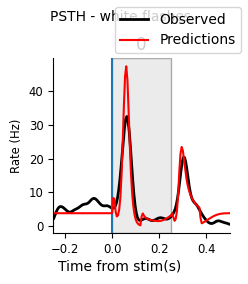

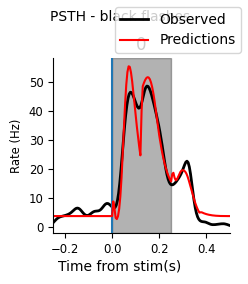

In [26]:
# visualize predicted psth
plot_pop_psth(peri_white[unit_id], "white", predictions=("red", peri_white_pred_unit))
plot_pop_psth(peri_black[unit_id], "black", predictions=("red", peri_black_pred_unit))

### Visualize learned model filters

<div class="render-all">

- "Expand" model coefficients into filters.
- Visualize these filters.

When using basis functions, GLM coefficients are hard to interpret directly. Recall in the [current injection (search for "Visualize the current history model's learned filter")](visualize-filter-full) and [head direction (search for "We can plot the resluting response,")](head-direction-basis-users) notebooks; we can multiply these coefficients by the basis functions to create the filter for visualization. This can be done using [numpy.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) or [numpy.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

If you get stuck here, you can expand the following dropdown to see a hint and then expand the one after that to see a possible way of doing this.

:::{admonition} How to compute the filters?
:class: hint dropdown

There are two components here:

1. If you've used a single basis object, your `GLM` will have weights of shape `(n_basis_funcs,)` (equivalently, a `PopulationGLM` will have weights of shape `(n_basis_funcs, n_neurons)`). If you call your basis's [`evaluate_on_grid`](https://nemos.readthedocs.io/en/latest/generated/basis/nemos.basis.RaisedCosineLogConv.evaluate_on_grid.html#nemos.basis.RaisedCosineLogConv.evaluate_on_grid) method, you'll get back an array of shape `(window_size, n_basis_funcs)` containing the basis functions. You can then use either [numpy.matmul](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html) or [numpy.einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) to multiply the weights by the functions, computing the filter.

2. If you've used more than one basis object, how do you know which weights correspond to which basis? 

    You can slice the weights yourselves: each basis will have `n_basis_funcs` weights associated with it (where this is the argument passed on initialization and also an attribute of the object), and so you can do some algebra to figure out which weights correspond to which basis.

    However, if you have used a single [AdditiveBasis](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.html) object to construct your GLM, you can take advantage of its [`split_by_feature` method](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.split_by_feature.html#nemos.basis._basis.AdditiveBasis.split_by_feature) to do the splitting for you.

:::

:::{admonition} Code to compute the filters
:class: hint dropdown

If you have used a single [AdditiveBasis](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.html) object to construct your GLM (called `additive_basis` in the following), you can take advantage of its [`split_by_feature` method](https://nemos.readthedocs.io/en/latest/generated/_basis/nemos.basis._basis.AdditiveBasis.split_by_feature.html#nemos.basis._basis.AdditiveBasis.split_by_feature):

```{code-block} python
weights = additive_basis.split_by_feature(model.coef_, 0)
filters = {}
for k, v in weights.items():
    this_basis = additive_basis[k]
    _, this_basis = this_basis.evaluate_on_grid(this_basis.window_size)
    filters[k] = np.matmul(this_basis, v)
```

`filters` is then a dictionary whose keys match the `label` of each basis object and whose values are numpy arrays.

:::

</div>

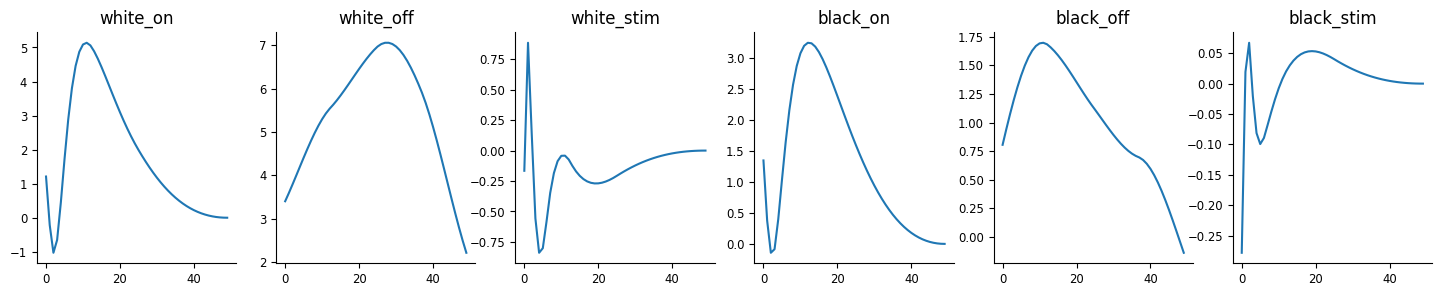

In [27]:
weights = additive_basis.split_by_feature(model.coef_, 0)
filters = {}
for k, v in weights.items():
    this_basis = additive_basis[k]
    _, this_basis = this_basis.evaluate_on_grid(this_basis.window_size)
    filters[k] = np.matmul(this_basis, v)
fig, axes = plt.subplots(1, len(filters), figsize=(3*len(filters), 3))
for ax, (k, v)  in zip(axes, filters.items()):
    ax.plot(v)
    ax.set_title(k)

### Score your model

<div class="render-all">

- We trained on the train set, so now we score on the test set. (Or use cross-validation.)
- Get a score for your model that you can use to compare across the modeling choices outlined above. (Hint: refer back to the [place cell ("How to know when to regularize?" header)](sklearn-cv-full) notebook.)

</div>

In [28]:
# Calculate the mean score for the Stimuli + Coupling model
# using pseudo-r2-McFadden
score = model.score(
    X_test,
    u_counts.restrict(flashes_test),
    score_type="pseudo-r2-McFadden"
)

print(score)

0.14181668


### Try to improve your model?

<div class="render-all">

- Go back to the beginning of [this section](visual-glm-users) and try to improve your model's performance (as reflected by increased score).
- Keep track of what you've tried and their respective scores. 
    - You can do this by hand, but constructing a [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), as we've seen in the [place cell ("How to know when to regularize?" header)](sklearn-cv-full), is useful:

</div>

In [29]:
# Example construction of dataframe.
# In this:
# - additive_basis is the single AdditiveBasis object we used to construct the entire design matrix
# - model is the GLM we fit to a single neuron
# - unit_id is the int identifying the neuron we're fitting
# - score is the float giving the model score, summarizing model performance (on the test set)
import pandas as pd
data = [
    {
        "model_id": 0,
        "regularizer": model.regularizer.__class__.__name__,
        "regularizer_strength": model.regularizer_strength,
        "solver": model.solver_name,
        "score": score,
        "n_predictors": len(additive_basis),
        "unit": unit_id,
        "predictor_i": i,
        "predictor": basis.label.strip(),
        "basis": basis.__class__.__name__,
        # any other info you think is important ...
    }
    for i, basis in enumerate(additive_basis)
]
df = pd.DataFrame(data)

df

,model_id,regularizer,regularizer_strength,solver,score,n_predictors,unit,predictor_i,predictor,basis
0,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,0,white_on,RaisedCosineLogConv
1,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,1,white_off,RaisedCosineLinearConv
2,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,2,white_stim,RaisedCosineLogConv
3,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,3,black_on,RaisedCosineLogConv
4,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,4,black_off,RaisedCosineLinearConv
5,0,Ridge,0.000008,LBFGS,0.14181668,6,951768318,5,black_stim,RaisedCosineLogConv
